In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#Import Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly
import plotly.offline as py

# Background

I decided to focus on one high volume location (Los Angeles, CA) to conduct my model application experiment. One location can share vehicles with another location, meaning experimenting on the entire company would overlook underfleeting. I created and tuned a fbprophet model for specifcically Los Angeles, CA.


# EDA

In [85]:
#Load lax time series sales demand for all 3 years
lax_ts = pd.read_csv('lax_ts.csv', parse_dates=['ds'])

lax_ts.head()

ds   y
0 2017-01-01  19
1 2017-01-02  31
2 2017-01-03  35
3 2017-01-04  26
4 2017-01-05  44

Discrete 


                stat
poisson        249.0
uniform        759.0
norm           929.0
expon         2504.0
bernoulli  4514978.0 




Using TensorFlow backend.


CNN Model
Prediction Index: [3]

Prediction class: ['poisson']


('Discrete',                 stat
 poisson        249.0
 uniform        759.0
 norm           929.0
 expon         2504.0
 bernoulli  4514978.0, ['poisson'])

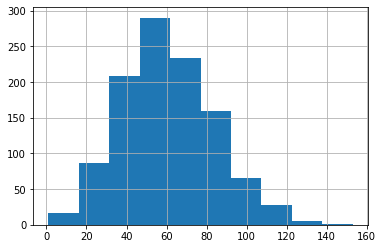

In [86]:
from Distribution_Classifier import Distribution_Detective

#Poisson good fit because this is a time series dataset predicting sales demand
Distribution_Detective(lax_ts, 'y')

# LAX FBProphet Untuned Model

In [18]:
#SEASONALITY TIME
#LETS ADD THE US HOLIDAYS SEASONALITY TO MODEL

def Run_FBProphet_Holidays(df, growth='linear', daily_seasonality='auto', 
                           seasonality_mode= 'additive', holidays=None, 
                           n_changepoints=25, changepoint_range=0.8, changepoints=None, 
                           changepoint_prior_scale=0.05):
    #Going to perform a Train Test Split to better evaluate the model

    full_len = len(df)
    train_len = int(.7*len(df))
    test_len = int(.3*len(df)+1)
    
    print('100%:{}\n70%:{}\n30%:{}'.format(full_len, train_len, test_len))
    
    
    train = df.iloc[:766].copy()
    test = df.iloc[766:].copy()

    print('Train df:{}\nTest df: {}'.format(train.shape,test.shape))
    
    #Intialilze model and fit training data
    m = Prophet(growth=growth, daily_seasonality=daily_seasonality, 
                seasonality_mode=seasonality_mode, holidays=holidays, 
                n_changepoints=n_changepoints, changepoint_range=changepoint_range, 
                changepoints=changepoints, changepoint_prior_scale=changepoint_prior_scale
                 )
    
    m.add_country_holidays(country_name='US')     
    m.fit(train)
    future = m.make_future_dataframe(periods=test_len, freq='D')
    forecast = m.predict(future)
    print('Forecast df: {}'.format(forecast.shape))
    print(forecast.columns)
    
    
    ax = forecast.plot(x='ds', y='yhat', label="Predictions", legend=True, figsize=(15,5))
    test.plot(x='ds',y='y', label="Test Data", legend=True, ax=ax)
    plt.title('Validation Plot: Full View')
    plt.ylabel('Sales Qty')
    plt.show()
    
    ax2 = forecast.plot(x='ds', y='yhat', label="Predictions", legend=True, figsize=(15,5))
    test.plot(x='ds',y='y', label="Test Data", legend=True, ax=ax2, xlim=(test['ds'].loc[train_len],test['ds'].loc[full_len-1]))
    plt.title('Validation Plot: Zoomed In')
    plt.ylabel('Sales Qty')
    plt.show()
    
    
    from statsmodels.tools.eval_measures import rmse

    predictions = forecast.iloc[-test_len:]['yhat']
    print('Predicions Shape: {}\n'.format(predictions.shape))
    
    rmse = rmse(predictions, test['y'])
    print("RMSE Score: {:.02f}".format(rmse))
    print('test_avg: {:.02f}'.format(test['y'].mean()))
    print('RMSE/test_avg: {:.02f}\n'.format(rmse/test['y'].mean()))
    
    print('fbprophet Model Params\nn_changepoints= {}\nchangepoint_range= {}\nchangepoints= {}\nchangepoint_prior_scale= {}\n\n'.format( 
    n_changepoints, changepoint_range, changepoints, changepoint_prior_scale ))
    
    print('Holdiay List\n{}'.format(m.train_holiday_names))
    ''' from fbprophet.plot import plot_components_plotly

    fig = plot_components_plotly(m, forecast)
    py.iplot(fig)'''
    m.plot_components(forecast)
    
    #Plotly is an interactive plot
    from fbprophet.plot import plot_plotly
    import plotly.offline as py
    py.init_notebook_mode()

    fig = plot_plotly(m, forecast)  # This returns a plotly Figure
    py.iplot(fig)

    return m, forecast 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%:1095
70%:766
30%:329
Train df:(766, 2)
Test df: (329, 2)
Forecast df: (1095, 58)
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Labor Day', 'Labor Day_lower', 'Labor Day_upper',
       'Martin Luther King Jr. Day', 'Martin Luther King Jr. Day_lower',
       'Martin Luther King Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiving_upper', 'Veterans Day', 'Veterans Day_lower',
       'Veterans Day_upper', 'Veterans Day (Observed)',
       'Veterans Day (Observed

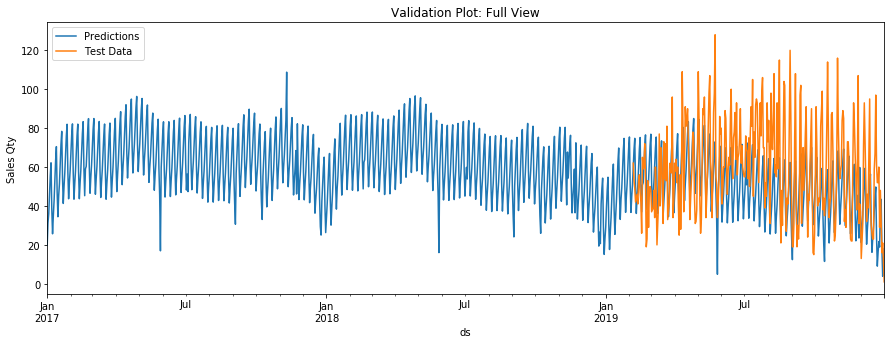

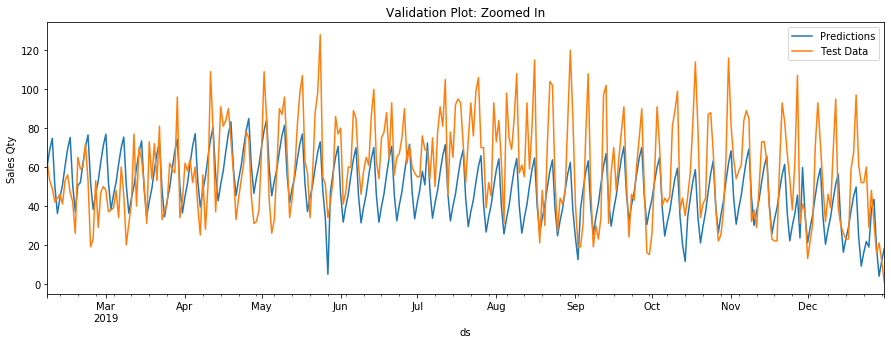

Predicions Shape: (329,)

RMSE Score: 22.32
test_avg: 59.17
RMSE/test_avg: 0.38

fbprophet Model Params
n_changepoints= 25
changepoint_range= 0.8
changepoints= None
changepoint_prior_scale= 0.05


Holdiay List
0                 New Year's Day
1      New Year's Day (Observed)
2     Martin Luther King Jr. Day
3          Washington's Birthday
4                   Memorial Day
5               Independence Day
6                      Labor Day
7                   Columbus Day
8                   Veterans Day
9        Veterans Day (Observed)
10                  Thanksgiving
11                 Christmas Day
dtype: object


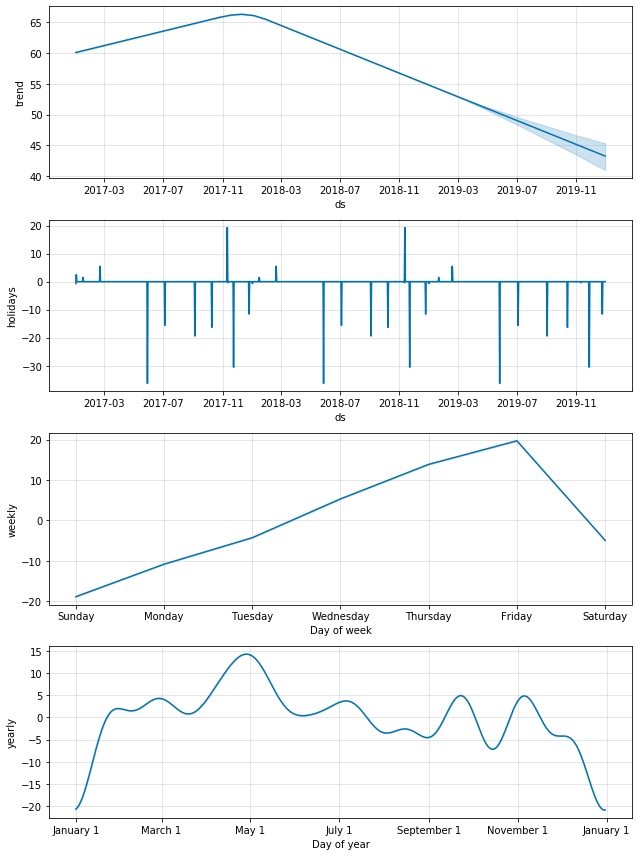

In [19]:
lax_prophet, lax_fcast = Run_FBProphet_Holidays(lax_ts)

# Trend Tuning

In [3]:
from prophet_tuner import Trend_God


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Best Parameter Found: 2
Best RMSE: 21.826412659314204
test_avg: 60.48
RMSE/test_avg: 0.36



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Best Parameter Found: 0.1
Best RMSE: 19.574080336702746
test_avg: 60.48
RMSE/test_avg: 0.32



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best Parameter Found: 0.1
Best RMSE: 23.10016709972011
test_avg: 60.48
RMSE/test_avg: 0.38



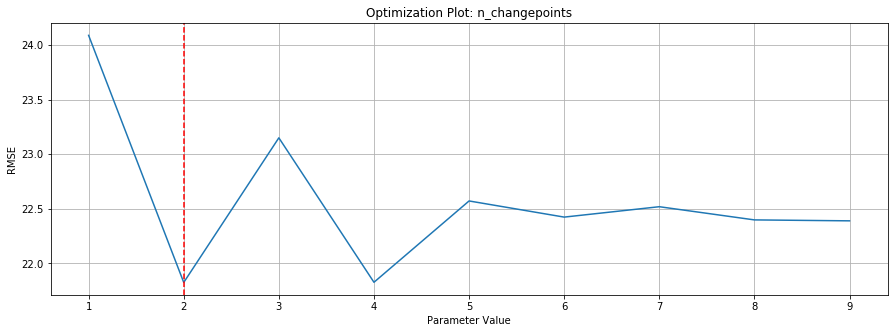

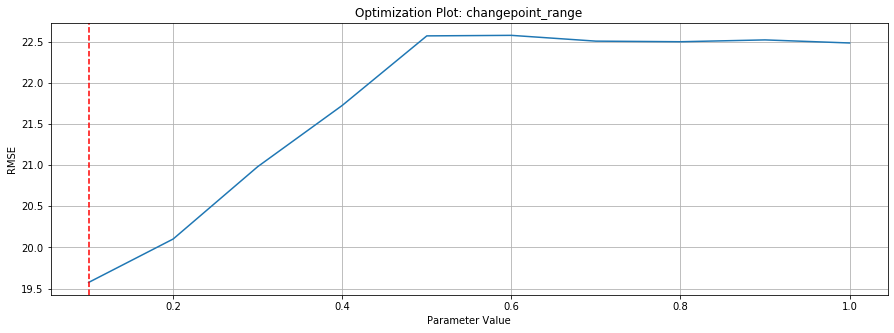

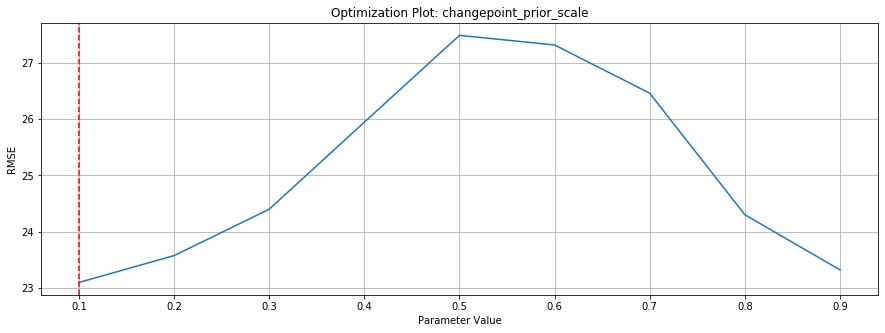

In [13]:
best_trend_param = Trend_God(lax_ts)

In [11]:
best_trend_param

{'n_changepoints': (2, 21.826412659314204),
 'change_point_range': (0.1, 19.574080336702746),
 'change_point_scale': (0.1, 23.10016709972011)}

### n_changepoints

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best Parameter Found: 2
Best RMSE: 19.357246138820425
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 2
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007


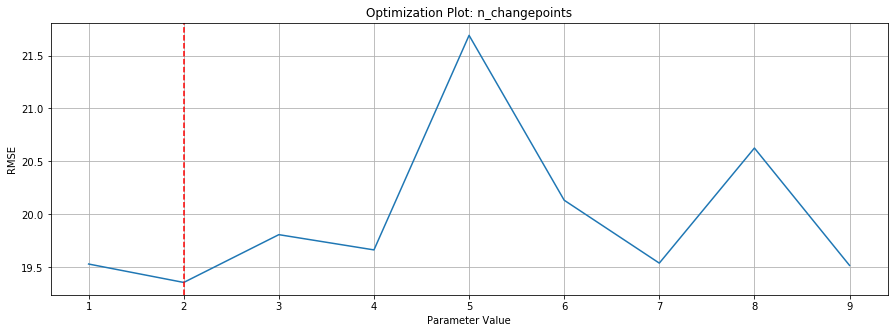

In [18]:
'''This model DOES NOT includes US Holiday Seasonality
Best Parameter Found: 2
Best RMSE: 19.357
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 2
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007'''


best_trend_param2 = Trend_God(lax_ts, cprange=False, cpscale=False, chng_r=0.1, chng_pr_sc=0.0007 )

In [16]:
best_trend_param2

{'n_changepoints': (2, 19.357246138820425)}

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best Parameter Found: 1
Best RMSE: 19.269665690366512
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 1
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007


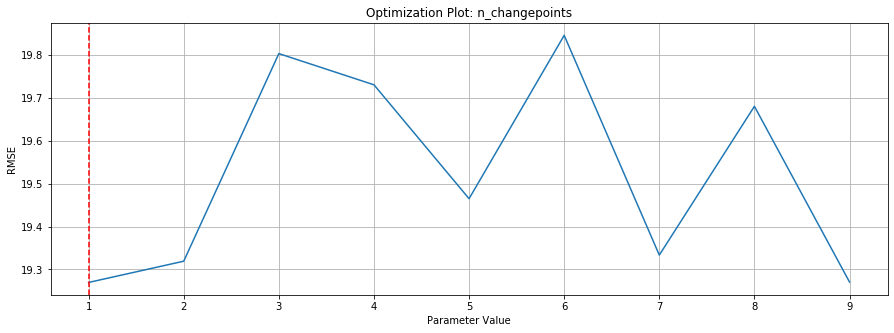

In [4]:
'''This model includes US Holiday Seasonality
Best Parameter Found: 1
Best RMSE: 19.269
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 1
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007'''

best_trend_nchng = Trend_God(lax_ts, cprange=False, cpscale=False, chng_r=0.1, chng_pr_sc=0.0007 )

In [5]:
best_trend_nchng

{'n_changepoints': (1, 19.269665690366512)}

### changepoint_range

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Best Parameter Found: 0.1
Best RMSE: 19.31067551955962
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 1
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007


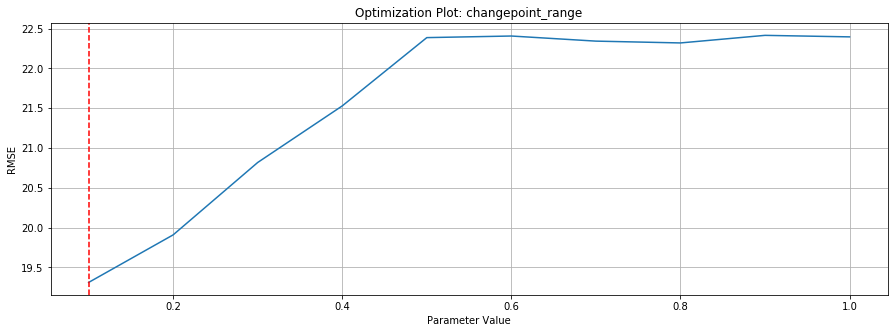

In [7]:
'''With Holiday Seasonality
Best Parameter Found: 0.1
Best RMSE: 19.31067551955962
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 1
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007'''
best_trend_cprange = Trend_God(lax_ts, changepoints=False, cpscale=False, n_chng=1,chng_pr_sc=0.0007 )

In [8]:
best_trend_cprange

{'change_point_range': (0.1, 19.31067551955962)}

### changepoint_prior_scale

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best Parameter Found: 0.0007
Best RMSE: 19.270119571391657
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 2
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007


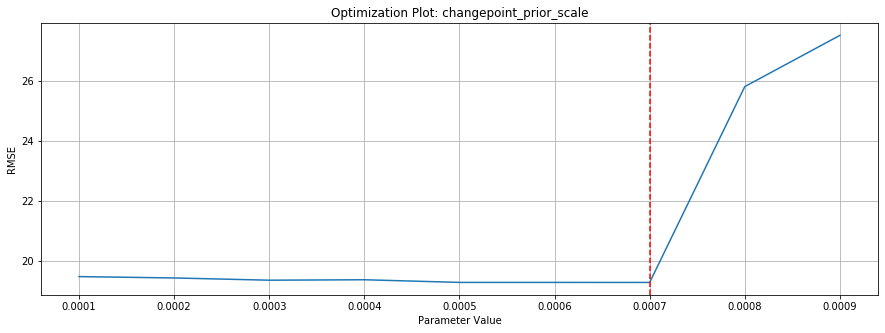

In [9]:
'''With Holiday Seasonality
Best Parameter Found: 0.0007
Best RMSE: 19.27
test_avg: 60.48
RMSE/test_avg: 0.32

CP Range Model Params
n_changepoints= 2
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007'''

best_trend_cpscale = Trend_God(lax_ts, changepoints=False, cprange=False, n_chng=2, chng_r=0.1)
                               

In [10]:
best_trend_cpscale

{'change_point_scale': (0.0007, 19.270119571391657)}

# LAX Trend Tuned Model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%:1095
70%:766
30%:329
Train df:(766, 2)
Test df: (329, 2)
Forecast df: (1095, 58)
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Labor Day', 'Labor Day_lower', 'Labor Day_upper',
       'Martin Luther King Jr. Day', 'Martin Luther King Jr. Day_lower',
       'Martin Luther King Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiving_upper', 'Veterans Day', 'Veterans Day_lower',
       'Veterans Day_upper', 'Veterans Day (Observed)',
       'Veterans Day (Observed

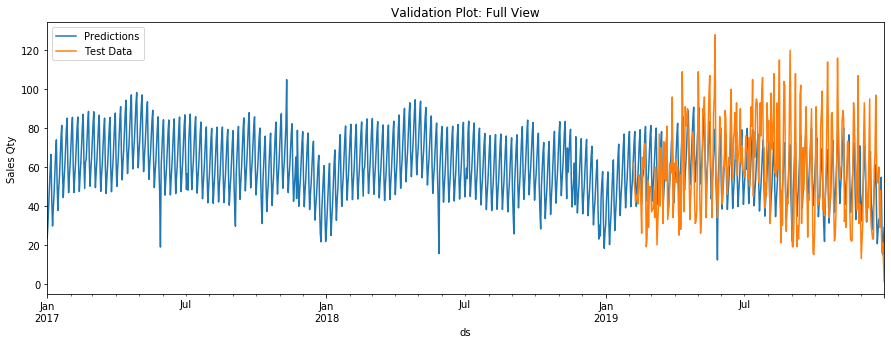

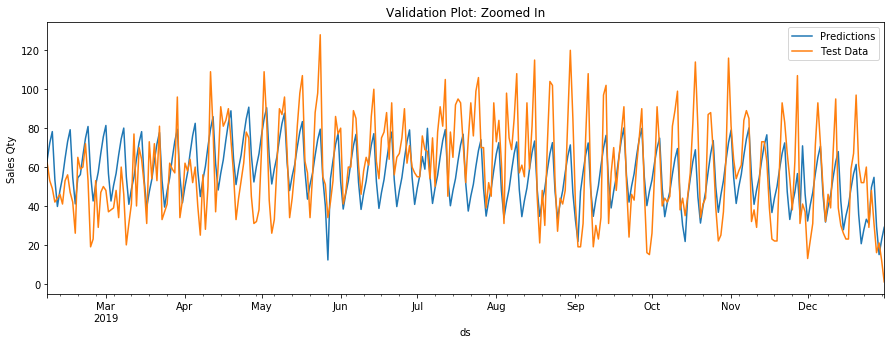

Predicions Shape: (329,)

RMSE Score: 19.27
test_avg: 59.17
RMSE/test_avg: 0.33

fbprophet Model Params
n_changepoints= 1
changepoint_range= 0.1
changepoints= None
changepoint_prior_scale= 0.0007


Holdiay List
0                 New Year's Day
1      New Year's Day (Observed)
2     Martin Luther King Jr. Day
3          Washington's Birthday
4                   Memorial Day
5               Independence Day
6                      Labor Day
7                   Columbus Day
8                   Veterans Day
9        Veterans Day (Observed)
10                  Thanksgiving
11                 Christmas Day
dtype: object


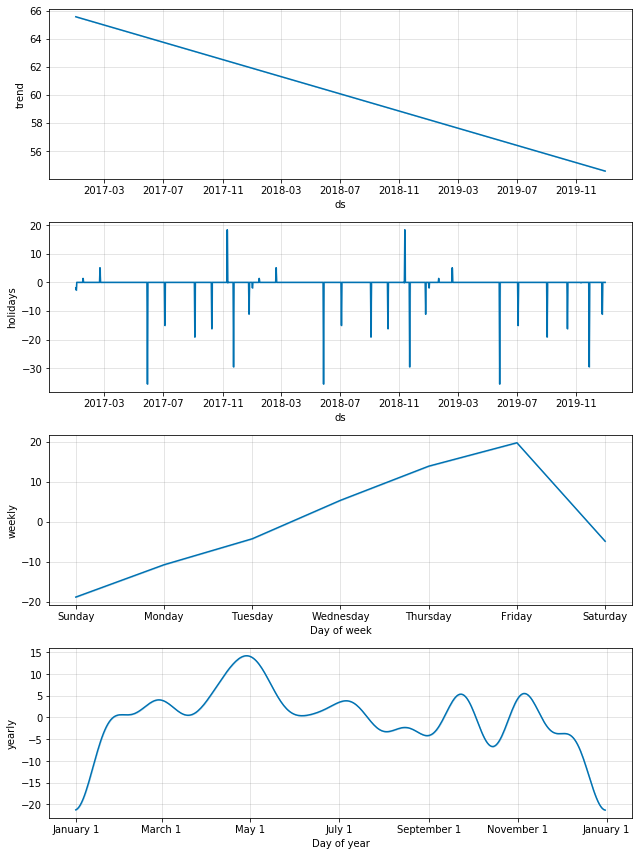

In [22]:
#NOTE This is inluding US holidays
lax_prophet_tuned, lax_fcast_tuned = Run_FBProphet_Holidays(lax_ts, n_changepoints=1, 
                                                            changepoint_range= 0.1,
                                                           changepoint_prior_scale= 0.0007)

# Predictions

In [31]:
#Add predictons to df
pred_2018 = lax_fcast_tuned[['ds','yhat']]

#Filter for only 2018 predictions because thats the fleet year info I have
pred_2018 = pred_2018[(pred_2018['ds']>'2017-12-31') & (pred_2018['ds']<'2019-01-01') ]

pred_2018

ds       yhat
365 2018-01-01  27.856668
366 2018-01-02  36.497524
367 2018-01-03  46.435205
368 2018-01-04  55.433185
369 2018-01-05  61.884773
..         ...        ...
725 2018-12-27  52.363621
726 2018-12-28  57.636523
727 2018-12-29  32.533532
728 2018-12-30  18.248996
729 2018-12-31  26.165368

[365 rows x 2 columns]

In [32]:
#Create a dataframe for only 2018 sales
lax_2018 = lax_ts[(lax_ts['ds']>'2017-12-31') & (lax_ts['ds']<'2019-01-01') ]

lax_2018

ds   y
365 2018-01-01  33
366 2018-01-02  62
367 2018-01-03  66
368 2018-01-04  64
369 2018-01-05  47
..         ...  ..
725 2018-12-27   9
726 2018-12-28  19
727 2018-12-29  14
728 2018-12-30   2
729 2018-12-31   1

[365 rows x 2 columns]

# Fleet Data

In [38]:
#Load fleet avail dat
lax_fleet = pd.read_csv('data/lax_fleet_tracker.csv', parse_dates=['Date'])

#Rename Date column to ds. This makes it easier to merge
lax_fleet.rename(columns={'Date':'ds'}, inplace=True)

lax_fleet

ds  Beg Fleet  Purchased Fleet  Sold Fleet  Ending Fleet  \
0   2018-01-01        394                0           0           394   
1   2018-01-02        394                2           0           396   
2   2018-01-03        396                0           0           396   
3   2018-01-04        396                0           0           396   
4   2018-01-05        396                0           0           396   
..         ...        ...              ...         ...           ...   
360 2018-12-27        294                0           0           294   
361 2018-12-28        294                0           0           294   
362 2018-12-29        294                0           0           294   
363 2018-12-30        294                0           0           294   
364 2018-12-31        294                0           0           294   

     Fleet Rented  Fleet Returned  Fleet Avail  
0              33               0          361  
1              62               2          303  
2              66              10          247  
3              64              24          207  
4              47              31          191  
..            ...             ...          ...  
360             9              33           93  
361            19              42          116  
362            14              37          139  
363             2              51          188  
364             1             107          294  

[365 rows x 8 columns]

In [39]:
lax_fleet.ds

0     2018-01-01
1     2018-01-02
2     2018-01-03
3     2018-01-04
4     2018-01-05
         ...    
360   2018-12-27
361   2018-12-28
362   2018-12-29
363   2018-12-30
364   2018-12-31
Name: ds, Length: 365, dtype: datetime64[ns]

In [40]:
#Combine Fleet data and model predictions for 2018
lax_combined_2018 = pd.merge(lax_fleet,pred_2018, on='ds', )

lax_combined_2018

ds  Beg Fleet  Purchased Fleet  Sold Fleet  Ending Fleet  \
0   2018-01-01        394                0           0           394   
1   2018-01-02        394                2           0           396   
2   2018-01-03        396                0           0           396   
3   2018-01-04        396                0           0           396   
4   2018-01-05        396                0           0           396   
..         ...        ...              ...         ...           ...   
360 2018-12-27        294                0           0           294   
361 2018-12-28        294                0           0           294   
362 2018-12-29        294                0           0           294   
363 2018-12-30        294                0           0           294   
364 2018-12-31        294                0           0           294   

     Fleet Rented  Fleet Returned  Fleet Avail       yhat  
0              33               0          361  27.856668  
1              62               2          303  36.497524  
2              66              10          247  46.435205  
3              64              24          207  55.433185  
4              47              31          191  61.884773  
..            ...             ...          ...        ...  
360             9              33           93  52.363621  
361            19              42          116  57.636523  
362            14              37          139  32.533532  
363             2              51          188  18.248996  
364             1             107          294  26.165368  

[365 rows x 9 columns]

In [ ]:
#Save combined table to csv file
#lax_combined_2018.to_csv('lax_combined_2018.csv')

# Cost Benefit Matrix

- **Experiment Reality:**
  - Cars can be purchased and sold every day with no lag.
  - There is an immediate buyer for vans to be sold.
  - There is immediate funding for vans to be purchased.
  


- **Rules**
  - Optimal fleet availabitiy is double the predicted demand.
  - Any fleet greater than one but less than the double mark will benefit the company **400 Dollars** per car.
  - Any fleet over the double mark will cost the company **400 Dollars** per vehicle.
  - Anytime fleet is in the negative it will cost the company **200 Dollars** in revenue per vehicle.

In [49]:
#Add needed columns to Cost Matrix
cost_matrix = lax_combined_2018[ [ 'ds','Fleet Rented', 'Fleet Returned','Fleet Avail', 'yhat' ]]

#Convert predictions to whole number
cost_matrix['yhat'] = round(cost_matrix['yhat'])

cost_matrix

ds  Fleet Rented  Fleet Returned  Fleet Avail  yhat
0   2018-01-01            33               0          361  28.0
1   2018-01-02            62               2          303  36.0
2   2018-01-03            66              10          247  46.0
3   2018-01-04            64              24          207  55.0
4   2018-01-05            47              31          191  62.0
..         ...           ...             ...          ...   ...
360 2018-12-27             9              33           93  52.0
361 2018-12-28            19              42          116  58.0
362 2018-12-29            14              37          139  33.0
363 2018-12-30             2              51          188  18.0
364 2018-12-31             1             107          294  26.0

[365 rows x 5 columns]

In [50]:
#Create optimal fleet column at double the predicted sales
cost_matrix['Optimal Fleet']= cost_matrix['yhat']*2

cost_matrix

ds  Fleet Rented  Fleet Returned  Fleet Avail  yhat  Optimal Fleet
0   2018-01-01            33               0          361  28.0           56.0
1   2018-01-02            62               2          303  36.0           72.0
2   2018-01-03            66              10          247  46.0           92.0
3   2018-01-04            64              24          207  55.0          110.0
4   2018-01-05            47              31          191  62.0          124.0
..         ...           ...             ...          ...   ...            ...
360 2018-12-27             9              33           93  52.0          104.0
361 2018-12-28            19              42          116  58.0          116.0
362 2018-12-29            14              37          139  33.0           66.0
363 2018-12-30             2              51          188  18.0           36.0
364 2018-12-31             1             107          294  26.0           52.0

[365 rows x 6 columns]

In [51]:
#Add cost column to df

cost_matrix['cost'] = (cost_matrix['Optimal Fleet'] - cost_matrix['Fleet Avail'])*400

cost_matrix

ds  Fleet Rented  Fleet Returned  Fleet Avail  yhat  \
0   2018-01-01            33               0          361  28.0   
1   2018-01-02            62               2          303  36.0   
2   2018-01-03            66              10          247  46.0   
3   2018-01-04            64              24          207  55.0   
4   2018-01-05            47              31          191  62.0   
..         ...           ...             ...          ...   ...   
360 2018-12-27             9              33           93  52.0   
361 2018-12-28            19              42          116  58.0   
362 2018-12-29            14              37          139  33.0   
363 2018-12-30             2              51          188  18.0   
364 2018-12-31             1             107          294  26.0   

     Optimal Fleet      cost  
0             56.0 -122000.0  
1             72.0  -92400.0  
2             92.0  -62000.0  
3            110.0  -38800.0  
4            124.0  -26800.0  
..             ...       ...  
360          104.0    4400.0  
361          116.0       0.0  
362           66.0  -29200.0  
363           36.0  -60800.0  
364           52.0  -96800.0  

[365 rows x 7 columns]

In [52]:
#If the van rental company used the model it would have saved $361K in 2018
cost_matrix['cost'].sum()

-360800.0

In [53]:
#Create csv file to save results
#cost_matrix.to_csv('LAX_Cost_Matrix_2018.csv')

2018 Total Cost: -360800.00
Avg Daily Cost:  -988.49


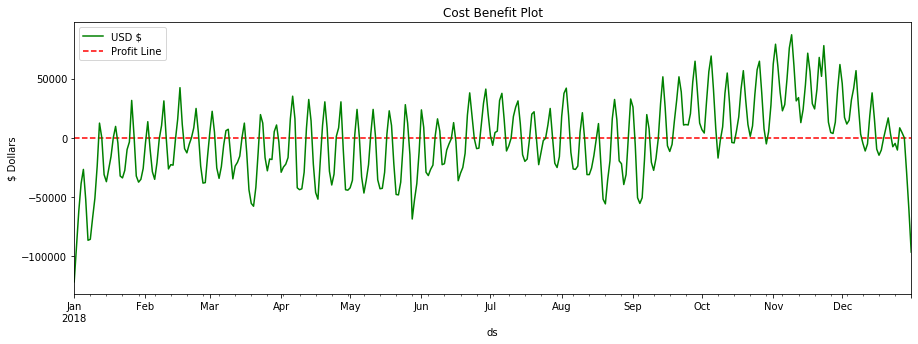

In [99]:
print('2018 Total Cost: {:.02f}'.format(cost_matrix['cost'].sum() ))
print('Avg Daily Cost:  {:.02f}'.format(cost_matrix['cost'].mean()))

cost_matrix.plot(x='ds', y='cost', figsize=(15,5), color='g' )
plt.hlines(0, xmin='2018-01-01', xmax='2018-12-31', 
           linestyles='--', colors='r', label='Profit Line')
plt.ylabel('$ Dollars')
plt.legend(['USD $', 'Profit Line'])
plt.title('Cost Benefit Plot');

In [73]:
#This is an interactive plot for LAX cost benefit via the model predictions
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=cost_matrix.ds, y=cost_matrix.cost))
fig.show()

In [81]:
#WEEKLY VIEW of DATA
weekly_cost = cost_matrix.set_index('ds').resample('W').sum()

weekly_cost

Fleet Rented  Fleet Returned  Fleet Avail   yhat  Optimal Fleet  \
ds                                                                            
2018-01-07           311             182         1782  290.0          580.0   
2018-01-14           458             334         1292  336.0          672.0   
2018-01-21           483             500         1053  393.0          786.0   
2018-01-28           442             447         1038  427.0          854.0   
2018-02-04           424             415         1190  435.0          870.0   
2018-02-11           457             452          974  435.0          870.0   
2018-02-18           486             442          854  442.0          884.0   
2018-02-25           435             476          928  458.0          916.0   
2018-03-04           445             435         1128  457.0          914.0   
2018-03-11           498             490         1145  447.0          894.0   
2018-03-18           453             465         1131  436.0          872.0   
2018-03-25           482             414         1248  433.0          866.0   
2018-04-01           465             498         1093  445.0          890.0   
2018-04-08           472             510         1028  465.0          930.0   
2018-04-15           514             470         1190  490.0          980.0   
2018-04-22           499             522         1267  511.0         1022.0   
2018-04-29           508             549         1257  523.0         1046.0   
2018-05-06           488             456         1363  520.0         1040.0   
2018-05-13           476             477         1278  499.0          998.0   
2018-05-20           467             429         1190  469.0          938.0   
2018-05-27           446             422         1177  444.0          888.0   
2018-06-03           422             461         1210  394.0          788.0   
2018-06-10           430             420         1054  425.0          850.0   
2018-06-17           434             461         1019  428.0          856.0   
2018-06-24           461             380          852  434.0          868.0   
2018-07-01           429             425          670  441.0          882.0   
2018-07-08           431             463          672  432.0          864.0   
2018-07-15           503             508          720  442.0          884.0   
2018-07-22           397             415          902  425.0          850.0   
2018-07-29           421             414          812  405.0          810.0   
2018-08-05           446             423          635  396.0          792.0   
2018-08-12           397             453         1006  398.0          796.0   
2018-08-19           380             433         1136  400.0          800.0   
2018-08-26           408             369          958  395.0          790.0   
2018-09-02           352             337          876  388.0          776.0   
2018-09-09           333             380         1176  376.0          752.0   
2018-09-16           410             403          713  423.0          846.0   
2018-09-23           436             413          572  448.0          896.0   
2018-09-30           470             473          374  445.0          890.0   
2018-10-07           416             420          278  409.0          818.0   
2018-10-14           347             370          447  358.0          716.0   
2018-10-21           388             357          345  373.0          746.0   
2018-10-28           377             399          269  404.0          808.0   
2018-11-04           432             364          209  440.0          880.0   
2018-11-11           482             499            1  446.0          892.0   
2018-11-18           400             397          198  439.0          878.0   
2018-11-25           329             362          -79  366.0          732.0   
2018-12-02           415             405          302  385.0          770.0   
2018-12-09           311             344          291  381.0  

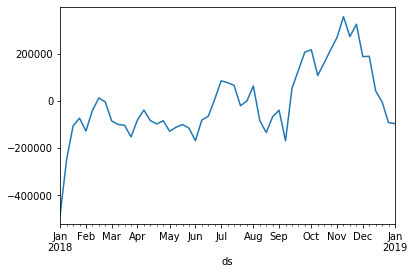

In [83]:
weekly_cost['cost'].plot()